<a href="https://colab.research.google.com/github/pgordin/GraphsSN2025/blob/main/Graphs_8b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Graphs & Social Networks &mdash; lab material
This notebook contains a definition of a python class *Graph*, containing functions described during labs.

Package import.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import random, seed
from copy import deepcopy
from queue import PriorityQueue

## Simple functions from the first classes
This is left just as an example (to compare the behaviour).

In [2]:
def print_matrix(vertices, matrix):
  """
  Printing a graph given by adjacency matrix
  """
  n = len(matrix)
  if (vertices is not None) and (len(vertices) == n):
    vv = vertices
  else:
    vv = range(1, n+1)
  for i in range(n):
    print(vv[i], ":", end="")
    for j in range(n):
      if matrix[i, j]:
        print(" ", vv[j], end="")
    print("")

def print_dict(graph):
  """
  Printing of a graph (given as a dictionary/neighbouring list)
  """
  for v in graph:
    print(v, ":", end="")
    for u in graph[v]:
      print(" ", u, end="")
    print("")

## Class *Graph*

In [3]:
class Graph:
    def __init__(self, graph=None):
        if graph is None:
            graph = {}
        self.graph = graph

    # dict initializer
    @classmethod
    def from_dict(cls, graph):
        return cls(graph)

    # array initializer
    @classmethod
    def from_matrix(cls, matrix, vertices = None):
        if (vertices is None) or (len(vertices) != len(matrix)):
            vertices = [*range(1, len(matrix) + 1)]
        return cls.from_dict(cls._matrix_to_dict(matrix, vertices))

    # two private methods matrix <-> dictionaries
    def _matrix_to_dict(matrix, vertices: list) -> dict:
        """
        Converts a graph given as an adjacency matrix to a graph in dict form.
        """
        res_dict = {}
        for i, v in enumerate(vertices):
            neighbours = [vertices[j] for j, edge in enumerate(matrix[i]) if edge]
            res_dict[v] = neighbours
        return res_dict

    def _dict_to_matrix(self, _dict: dict) -> np.array:
        """
        Converts a graph in dict form to its adjacency matrix.
        """
        n = len(_dict)
        vertices = [*_dict.keys()]
        matrix = np.zeros(shape = (n, n), dtype=int)
        for u,v in [
            (vertices.index(u), vertices.index(v))
            for u, row in _dict.items() for v in row
        ]:
            matrix[u][v] += 1
        return matrix

    def vertices(self) -> list:
        """
        Returns list of vertices of the graph.
        """
        return [*self.graph.keys()]

    def matrix(self) -> np.array:
        """
        Returns the adjacency matrix of the graph.
        """
        return self._dict_to_matrix(self.graph)

    # redefinition of print for objects of class Graph
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}"
            res += "\n"
        return res

    def plot(self, directed = 0):
      """
      Plots the graph using networkx package.
      """
      if directed:
        G = nx.DiGraph(self.graph)
      else:
        G = nx.Graph(self.graph)
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True)
      plt.show()


    # The following is for free thanks to the above
    def to_neighbourlist(self, filename: str):
        """
        Saves a graphs to a text file as a neighbour dict.\n
        Filename is a file path.
        """
        file = open(filename, "w")  # open textfile for writing
        file.write(str(self))
        file.close()

    # Modyfying graphs
    def add_vertex(self, vertex):
        """
        Adds a new vertex to the graph.
        """
        if vertex not in self.graph:
            self.graph[vertex] = []

    def del_vertex(self, vertex):
        """
        Removes a vertex from the graph.
        """
        if vertex in self.graph:
            self.graph.pop(vertex)
            for u in self.graph:
                if vertex in self.graph[u]:
                    self.graph[u].remove(vertex)

    def add_arc(self, arc):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        u, v = arc
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)

    def add_edge(self, edge: list):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        if u == v:
            raise ValueError("Loops are not allowed!")
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)
        if u not in self.graph[v]:
            self.graph[v].append(u)

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = Graph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) >= 2:             # at least two words, first two are the edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
        file.close()
        return graph

    @staticmethod
    def random_graph(n: int, p: float):
        """
        Creates a random graph in G(n, p) model.
        """
        rand_graph = Graph()
        for i in range(1, n + 1):
            rand_graph.add_vertex(i)
            for j in range(1, i):
                if random() < p:
                    rand_graph.add_edge([i, j])
        return rand_graph

    @staticmethod
    def random_bipartite_graph(m, n, p):
        """
        Creates a random bipartite graph G(m, n, p) model.
        m: number of vertices in the first partition.
        n: number of vertices in the second partition.
        p: probability of an edge between vertices from different partitions.
        """
        bipartite_graph = Graph()
        for i in range(1, m + n + 1):
            bipartite_graph.add_vertex(i)

        for u in range(1, m + 1):
            for w in range(m + 1, m + n + 1):
                if random() < p:
                    bipartite_graph.add_edge([u, w])
        return bipartite_graph

    @staticmethod
    def cycle(n: int):
        """
        Creates a cycle C_n on n vertices
        """
        cycle = Graph()
        for i in range(n-1):
          cycle.add_edge([i+1, i+2])
        cycle.add_edge([1, n])
        return cycle


    def Prufer(self):
      """
      Returns the Prufer code of a tree.
      It is necessary that the graph is a tree (it is not checked).
      Result is given as a string (empty for trees on 1 or 2 vertices).
      """
      tr = deepcopy(self.graph)   # copy of a tree, as we destroy it
      code = ""
      for i in range(len(self.graph) - 2):
        for x in sorted(tr):
          if len(tr[x]) == 1:   # least leaf
            break
        v = tr[x][0]            # the unique neighbour of x
        code = code + f"{v} "
        tr[v].remove(x)         # remove x from neighbours of v
        tr.pop(x)               # remove x from the tree
      return code.strip()

    @staticmethod
    def tree_from_Prufer(code: str):
        """
        Creating a tree from a Prufer code.
        """
        tree = Graph()
        clist = [int(x) for x in code.strip().split()]   # code as a list of numbers
        n = len(clist) + 2                  # number of vertices
        vert = [*range(1, n+1)]             # list of numbers 1..n
        for v in vert:
          tree.add_vertex(v)
        for i in range(n-2):
          for x in vert:
            if not x in clist:    # x - least leaf
              break
          v = clist.pop(0)    # remove the first element from the code - the neighbour of x
          tree.add_edge((x, v))
          vert.remove(x)
        tree.add_edge(vert)
        return tree


    def connected_components(self):
      """
      Looks for connected components of undirected graph.
      Returns a list of its vertex-sets.
      Remark: the first element contains the set of all graph vertices
      """
      def DFS(u):
        """
        Deep first search (as internal method).
        """
        for w in self.graph[u]:
          if w not in VT[0]:      # w - not visited yet
            VT[0].add(w)          # already visited
            VT[-1].add(w)         # w - in the last connected component
            DFS(w)

      """
      VT - list of vertex sets VT[i] for i > 0 - is a vertex set of i-th connected component
      VT[0] - is a vertex set of the spanning forest (or during the algorithm list of visited vertices).
      """
      VT = [set([])]
      for v in self.graph:
        if v not in VT[0]:      # v is not visited
          VT[0].add(v)
          VT.append(set([v]))   # statring point of new conected component
          DFS(v)
      return VT

    def preorder(self, v, visited=None):
        """
        Performs a pre-order traversal starting from vertex v and prints the vertices.
        """
        if visited is None:
            visited = set()

        if v not in visited:
            print(v, end=" ")
            visited.add(v)
            for neighbor in self.graph.get(v, []):
                self.preorder(neighbor, visited)

    def postorder(self, v, visited=None):
        """
        Performs a post-order traversal starting from vertex v and prints the vertices.
        """
        if visited is None:
            visited = set()

        if v not in visited:
            visited.add(v)
            for neighbor in self.graph.get(v, []):
                self.postorder(neighbor, visited)
            print(v, end=" ")

    def InducedSubgraph(self, V):
        """
        Returns a subgraph induced by the vertex set V.
        """
        subgraph = Graph()
        for v in V:
            subgraph.add_vertex(v)
            for w in self.graph[v]:
                if w in V:
                    subgraph.add_arc([v, w])
        return subgraph


    def ConnectedComponentsGraphs(self):
        """
        Returns a list of graphs, where each graph represents a connected component.
        Uses the existing connected_components method to find vertex sets.
        """
        components_vertex_sets = self.connected_components()
        list_of_component_graphs = []

        for component_set in components_vertex_sets[1:]:
            component_graph = Graph()
            for u in component_set:
                #component_graph.add_vertex(u)              # more general and elegant
                #for v in self.graph[u]:
                #  component_graph.add_arc([u, v])
                component_graph.graph[u] = self.graph[u]    # simply does the same stuff
            list_of_component_graphs.append(component_graph)

        return list_of_component_graphs

    def distance(self, v):
      """
      Computes the distance from vertex v to all other reachable vertices in the graph.
      It uses the BFS approach.
      Result is given as a dictionary of distances.
      """
      dist = {v: 0}     # starting point of a dictionary
      queue = [v]
      while len(queue) > 0:
        u = queue.pop(0)
        for w in self.graph[u]:
          if w not in dist:     # w not visited already
            dist[w] = dist[u] + 1
            queue.append(w)
      return dist

    def GeneralisedDFS(self):
      """
      DFS with a timer.
      """
      global timer

      def DFS(v):
        """
        Internal DFS
        """
        global timer
        visited[v] = timer
        for u in self.graph[v]:
          if u not in visited:
            timer += 1
            DFS(u)
        processed[v] = timer

      timer = 0
      visited = {}
      processed = {}
      for v in self.graph:
        if v not in visited:
          DFS(v)
      return visited, processed

    def TopologicalSort2(self):
      """
      Returns a list of vertices in topological order:
      Lecture version, without checking acyclicity
      """
      ordering = {}
      vis, pro = self.GeneralisedDFS()
      for v in self.graph:
        ordering[v] = pro[v]*len(self.graph) - vis[v]
      order = sorted(ordering, key=ordering.get, reverse=True)

      return ordering, order

## Class *WeightedGraph*

In [29]:
class WeightedGraph(Graph):
    def __init__(self, graph=None, weights=None):
        if weights is None:
            weights = {}
        self.weights = weights
        super().__init__(graph)

    #redefinition of printing and plotting
    def __str__(self):
        res = ""
        #res = super().__str__()
        #res += '-------------------------\n'
        for v in self.graph:
            res += f'{v}: '
            for u in self.graph[v]:
                res += f'{u}({self.weights[(v, u)]}) '
            res += '\n'
        return res

    def plot(self, directed = 0):
      """
      Plots the graph using networkx package.
      """
      if directed:
        G = nx.DiGraph(self.graph)
      else:
        G = nx.Graph(self.graph)
      nx.set_edge_attributes(G, self.weights, 'weight')
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True, node_color='lightblue')
      edge_labels = nx.get_edge_attributes(G, 'weight')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
      plt.show()

    # Modyfying graphs
    def del_vertex(self, v):
      """
      Removes a vertex from the graph.
      """
      # TODO - should be done in a different way
      super().del_vertex(v)

    def add_arc(self, arc, weight = 1):
       """
       Given pair of vertices (arc variable) add an arc to the graph
       We consider simple, directed graphs.
       """
       super().add_arc(arc)
       u, v = arc
       self.weights[(u, v)] = weight

    def add_edge(self, edge, weight = 1):
       """
       Given pair of vertices (edge variable) add an edge to existing graph.
       We consider simple, undirected graphs, as symmetric digraphs without loops.
       """
       super().add_edge(edge)
       u, v = edge
       self.weights[(u, v)] = weight
       self.weights[(v, u)] = weight

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        When we have at least 3 words we assume the third one is an edge weight (of type int).
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = WeightedGraph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) == 2:             # exactly two words, unweghted edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
          elif len(words) >= 3:             # at least three words, weighted edge description
            if directed:
              graph.add_arc([words[0], words[1]], int(words[2]))
            else:
              graph.add_edge([words[0], words[1]], int(words[2]))
        file.close()
        return graph

    def min_spanning_tree(self):
      """
      Computes a minimum spanning tree using Jarnik - Prim's algorithm.
      """
      for v in self.graph:    # choose any vertex of a graph
        break
      wtree = WeightedGraph()
      wtree.add_vertex(v)
      total_weight = 0
      q = PriorityQueue()
      for w in self.graph[v]:
        q.put((self.weights[(v, w)], v, w))
      while not q.empty():
        weight, u, v = q.get()
        if v not in wtree.graph:
          wtree.add_edge([u, v], weight)
          total_weight += weight
          for w in self.graph[v]:
            if w not in wtree.graph:
              q.put((self.weights[(v, w)], v, w))
      if len(wtree.graph) != len(self.graph):
        print("The graph is not connected! Returned is a spanning tree of some component.")
      return total_weight, wtree


    def Dijkstra(self, s):
      """
      Computes the shortest path from vertex s to all other reachable vertices in the graph.
      It uses the Dijkstra approach.
      Result is given as a dictionary of distances.
      """
      # initialization
      dist = {}     # distance dictionary
      pred = {}     # predecessors dictionary
      for v in self.graph:
        dist[v] = float('inf')
        pred[v] = None
      dist[s] = 0
      queue = PriorityQueue()
      queue.put((0, s))
      while not queue.empty():
        d, u = queue.get()
        if dist[u] < d:
          continue
        for v in self.graph[u]:
          # relaxation
          if dist[v] > dist[u] + self.weights[(u, v)]:
            dist[v] = dist[u] + self.weights[(u, v)]
            pred[v] = u
            queue.put((dist[v], v))
      return dist, pred

    def BellmanFord(self, s):
        """
        Bellman–Ford algorithm. Computes shortest paths from source s and detects negative-weight cycles.
        """
        dist = {v: float('inf') for v in self.graph} # all distances start as +∞
        pred = {v: None for v in self.graph} # predecessor dictionary
        dist[s] = 0
        vertices = list(self.graph.keys())
        n = len(vertices)
        for _ in range(n): # relax all edges|V|-1 times
            updated = False
            for u in self.graph: # iterate over all edges u → v
                for v in self.graph[u]:
                    w = self.weights[(u, v)] # weight
                    if dist[u] + w < dist[v]: # relaxation condition (better path)
                        dist[v] = dist[u] + w
                        pred[v] = u
                        updated = True # update happened
            if not updated:
                break

        has_negative_cycle = updated # check for negative-weight cycles
        return dist, pred, has_negative_cycle


    def network_flow(self):
      """
      Return the network flow (a graph with backward arcs) computed from original digraph.
      """
      network = WeightedGraph()
      for v in self.graph:
        network.add_vertex(v)
      for v in self.graph:
        for u in self.graph[v]:
          network.add_edge([v, u], 0)
      for xx in self.weights:
        network.weights[xx] = self.weights[xx]
      return network

    def MaxFlow_EK(self, s, t):
      """
      Computes the maximum flow from vertex s to vertex t using the Edmonds–Karp algorithm.
      Flow is returned as a dictionary of arc weights.
      """
      network = self.network_flow()
      flow = {xx: 0 for xx in network.weights}
      # compute the augmenting paths
      while True:
        pred ={s: None}   # dictionary of predecessors
        cap = {s: np.inf}   # dictionary of capacities
        queue = [s]
        # BFS starts
        while len(queue) > 0:
          u = queue.pop(0)
          for v in network.graph[u]:
            if (v not in pred) and (network.weights[(u, v)] - flow[(u, v)] > 0):
              pred[v] = u
              cap[v] = min(cap[u], network.weights[(u, v)] - flow[(u, v)])
              if v == t:
                break
              else:
                queue.append(v)
        if t in pred:
          # process the augmenting path
          v = t
          c = cap[t]
          while v != s:
            u = pred[v]
            flow[(u, v)] += c
            flow[(v, u)] -= c
            v = u
        else: # there is no augmenting path - the end
          break
      return flow



In [33]:
def positive_flow(flow):
  """
  Having flow (as dict) returns a positive flow (as dict).
  """
  return {xx: flow[xx] for xx in flow if flow[xx] > 0}


## Use of code

## Part 8

### Homework (Bellman-Ford)


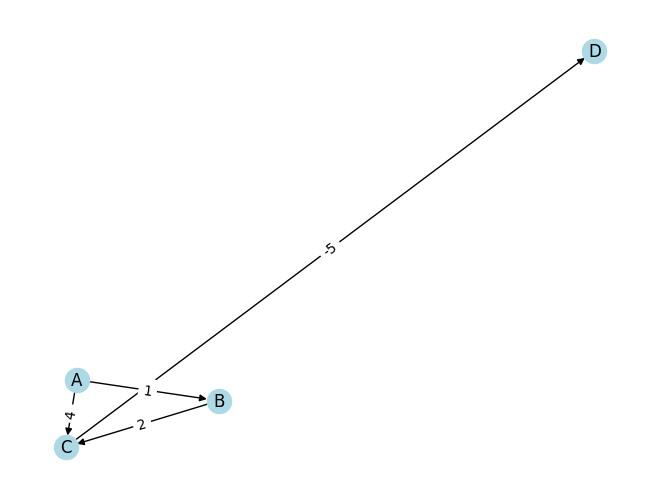

Distances: {'A': 0, 'B': 1, 'C': 3, 'D': -2}
Predecessors: {'A': None, 'B': 'A', 'C': 'B', 'D': 'C'}
Negative cycle? False


In [14]:
# No negative cycle

g = WeightedGraph()

for v in ["A", "B", "C", "D"]:
    g.add_vertex(v)

g.add_arc(["A", "B"], 1)
g.add_arc(["B", "C"], 2)
g.add_arc(["A", "C"], 4)
g.add_arc(["C", "D"], -5)

g.plot(1)

dist, pred, neg = g.BellmanFord("A")

print("Distances:", dist)
print("Predecessors:", pred)
print("Negative cycle?", neg)

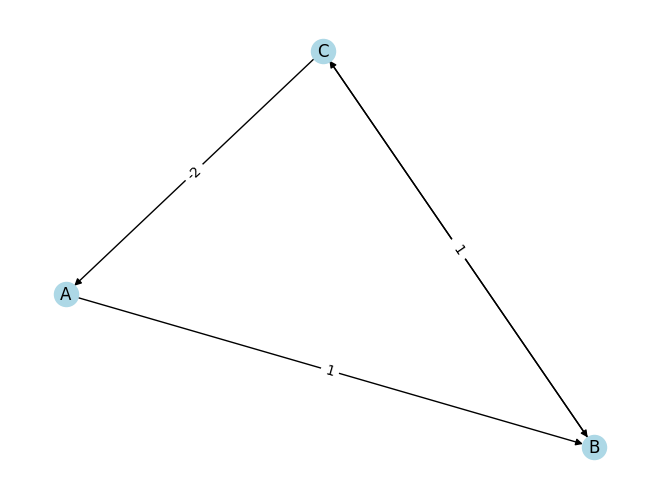

Distances: {'A': -9, 'B': -6, 'C': -7}
Predecessors: {'A': 'C', 'B': 'C', 'C': 'B'}
Negative cycle? True


In [15]:
# Negative cycle

g = WeightedGraph()

for v in ["A", "B", "C"]:
    g.add_vertex(v)

g.add_arc(["A", "B"], 1)
g.add_arc(["B", "C"], -2)
g.add_arc(["C", "B"], 1)
g.add_arc(["C", "A"], -2)  # negative cycle: A → B → C → A

g.plot(1)

dist, pred, neg = g.BellmanFord("A")

print("Distances:", dist)
print("Predecessors:", pred)
print("Negative cycle?", neg)

### Maximum flow

s: a(10) 
a: b(5) c(6) 
b: c(3) t(3) 
c: b(2) t(8) 
t: 



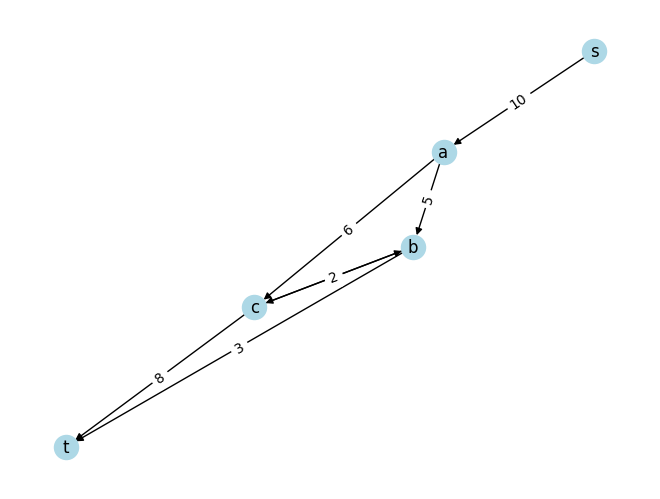

In [36]:
wgraph = WeightedGraph()
wgraph.add_arc(["s", "a"], 10)
wgraph.add_arc(["a", "b"], 5)
wgraph.add_arc(["a", "c"], 6)
wgraph.add_arc(["b", "c"], 3)
wgraph.add_arc(["c", "b"], 2)
wgraph.add_arc(["b", "t"], 3)
wgraph.add_arc(["c", "t"], 8)

print(wgraph)
wgraph.plot(1)

In [37]:
network1 = wgraph.network_flow()
print(network1)
#network1.plot(1)

s: a(10) 
a: s(0) b(5) c(6) 
b: a(0) c(3) t(3) 
c: a(0) b(2) t(8) 
t: b(0) c(0) 



In [38]:
flow = wgraph.MaxFlow_EK("s", "t")
print(flow)

{('s', 'a'): 10, ('a', 's'): -10, ('a', 'b'): 4, ('b', 'a'): -4, ('a', 'c'): 6, ('c', 'a'): -6, ('b', 'c'): 1, ('c', 'b'): -1, ('b', 't'): 3, ('t', 'b'): -3, ('c', 't'): 7, ('t', 'c'): -7}


In [39]:
print(positive_flow(flow))

{('s', 'a'): 10, ('a', 'b'): 4, ('a', 'c'): 6, ('b', 'c'): 1, ('b', 't'): 3, ('c', 't'): 7}


s: a(10) 
a: b(4) c(6) 
b: c(1) t(3) 
c: b(0) t(7) 
t: 



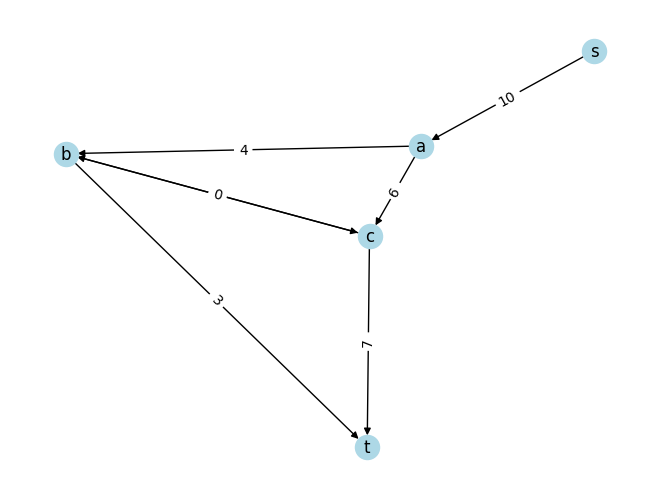

In [42]:
pos_flow = positive_flow(flow)
flowgraph = deepcopy(wgraph)
for xx in flowgraph.weights:
  flowgraph.weights[xx] = 0
for xx in pos_flow:
  flowgraph.weights[xx] = pos_flow[xx]
print(flowgraph)
flowgraph.plot(1)

In [43]:
!wget https://github.com/pgordin/GraphsSN2025/raw/refs/heads/main/MaxFlow.zip

--2025-12-08 14:42:10--  https://github.com/pgordin/GraphsSN2025/raw/refs/heads/main/MaxFlow.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pgordin/GraphsSN2025/refs/heads/main/MaxFlow.zip [following]
--2025-12-08 14:42:10--  https://raw.githubusercontent.com/pgordin/GraphsSN2025/refs/heads/main/MaxFlow.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3867 (3.8K) [application/zip]
Saving to: ‘MaxFlow.zip’

MaxFlow.zip         100%[===================>]   3.78K  --.-KB/s    in 0s      

2025-12-08 14:42:10 (42.9 MB/s) - ‘MaxFlow.zip’ saved [3867/3867]



In [44]:
!unzip MaxFlow.zip


Archive:  MaxFlow.zip
  inflating: 15w5a.txt               
  inflating: 20w5b.txt               
  inflating: bad10b.txt              
  inflating: bad100b.txt             
  inflating: bad100c.txt             
  inflating: flow1.txt               


In [45]:
wgraph2 = WeightedGraph.from_edges("flow1.txt")
print(wgraph2)

s: a(6) b(4) 
a: s(6) b(5) c(2) d(3) 
b: s(4) a(5) c(6) 
c: a(2) b(6) d(3) t(4) 
d: a(3) c(3) t(6) 
t: c(4) d(6) 



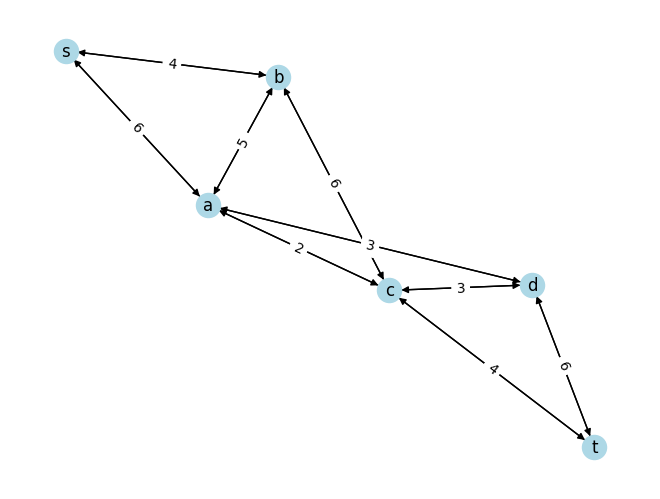

In [46]:
wgraph2.plot(1)

In [47]:
flow2 = wgraph2.MaxFlow_EK("s", "t")
print(flow2)

{('s', 'a'): 6, ('a', 's'): -6, ('s', 'b'): 4, ('b', 's'): -4, ('a', 'b'): 1, ('b', 'a'): -1, ('a', 'c'): 2, ('c', 'a'): -2, ('a', 'd'): 3, ('d', 'a'): -3, ('b', 'c'): 5, ('c', 'b'): -5, ('c', 'd'): 3, ('d', 'c'): -3, ('c', 't'): 4, ('t', 'c'): -4, ('d', 't'): 6, ('t', 'd'): -6}


In [48]:
print(positive_flow(flow2))

{('s', 'a'): 6, ('s', 'b'): 4, ('a', 'b'): 1, ('a', 'c'): 2, ('a', 'd'): 3, ('b', 'c'): 5, ('c', 'd'): 3, ('c', 't'): 4, ('d', 't'): 6}


s: a(6) b(4) 
a: s(0) b(1) c(2) d(3) 
b: s(0) a(0) c(5) 
c: a(0) b(0) d(3) t(4) 
d: a(0) c(0) t(6) 
t: c(0) d(0) 



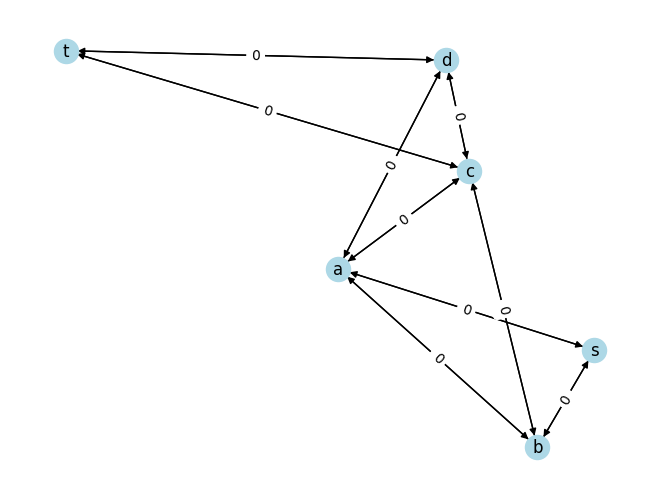

In [50]:
pos_flow2 = positive_flow(flow2)
flowgraph2 = deepcopy(wgraph2)
for xx in flowgraph2.weights:
  flowgraph2.weights[xx] = 0
for xx in pos_flow2:
  flowgraph2.weights[xx] = pos_flow2[xx]
print(flowgraph2)
flowgraph2.plot(1)

## Part 7 (Dijkstra's algorithm for shorthest paths)

In [ ]:
%%writefile "wgraph1.txt"
s a 10
s c 5
a b 2
a d 2
b c 7
c d 2

Writing wgraph1.txt


s: a(10) c(5) 
a: s(10) b(2) d(2) 
c: s(5) b(7) d(2) 
b: a(2) c(7) 
d: a(2) c(2) 



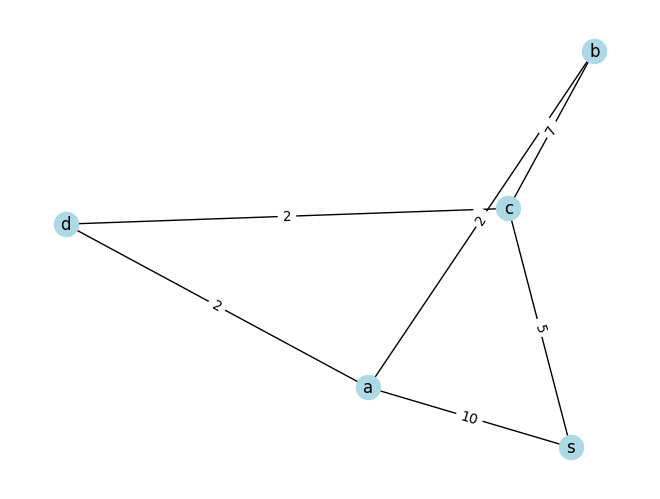

In [ ]:
wgraph1 = WeightedGraph.from_edges("wgraph1.txt")
print(wgraph1)
wgraph1.plot()

In [ ]:
dist, pred = wgraph1.Dijkstra("s")
print(dist)
print(pred)

{'s': 0, 'a': 9, 'c': 5, 'b': 11, 'd': 7}
{'s': None, 'a': 'd', 'c': 's', 'b': 'a', 'd': 'c'}


In [ ]:
!wget https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt

--2025-12-01 14:33:08--  https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt [following]
--2025-12-01 14:33:08--  https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114 [text/plain]
Saving to: ‘weighted0.txt’

weighted0.txt       100%[===================>]     114  --.-KB/s    in 0s      

2025-12-01 14:33:08 (5.72 MB/s) - ‘weighted0.txt’ saved [114/114]



A: B(3) E(10) 
B: A(3) C(26) D(12) 
E: A(10) D(7) F(8) H(4) 
C: B(26) D(17) F(13) G(14) 
D: B(12) C(17) E(7) F(15) 
F: C(13) D(15) E(8) G(9) H(6) 
G: C(14) F(9) H(16) I(11) 
H: E(4) F(6) G(16) 
I: G(11) 



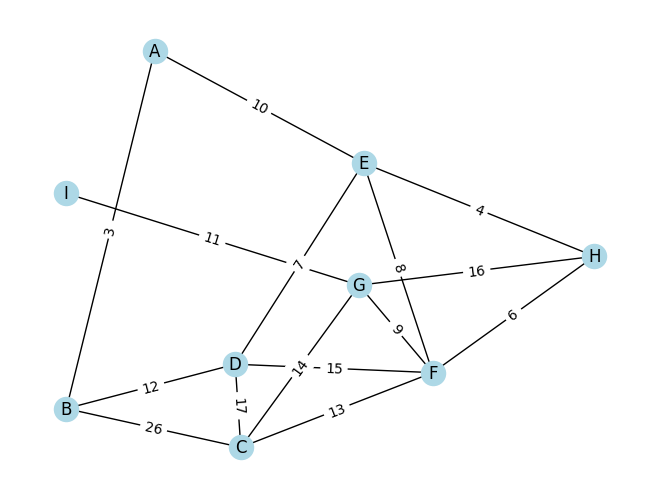

In [ ]:
wgraph2 = WeightedGraph.from_edges("weighted0.txt")
print(wgraph2)
wgraph2.plot()

In [ ]:
dist, pred = wgraph2.Dijkstra("A")
print(dist)
print(pred)

{'A': 0, 'B': 3, 'E': 10, 'C': 29, 'D': 15, 'F': 18, 'G': 27, 'H': 14, 'I': 38}
{'A': None, 'B': 'A', 'E': 'A', 'C': 'B', 'D': 'B', 'F': 'E', 'G': 'F', 'H': 'E', 'I': 'G'}


##Part 6 (weighted graphs)

In [ ]:
graph_dict = {
    'a': ['b', 'c'],
    'b': ['a', 'c', 'd'],
    'c': ['a', 'b'],
    'd': ['b', 'e'],
    'e': ['d']
}
weights_dict = {
    ('a', 'b'): 1,
    ('a', 'c'): 2,
    ('b', 'a'): 1,
    ('b', 'c'): 3,
    ('b', 'd'): 2,
    ('c', 'a'): 2,
    ('c', 'b'): 3,
    ('d', 'b'): 2,
    ('d', 'e'): 3,
    ('e', 'd'): 3
}
wgraph = WeightedGraph(graph_dict, weights_dict)
print(wgraph)

a: b(1) c(2) 
b: a(1) c(3) d(2) 
c: a(2) b(3) 
d: b(2) e(3) 
e: d(3) 



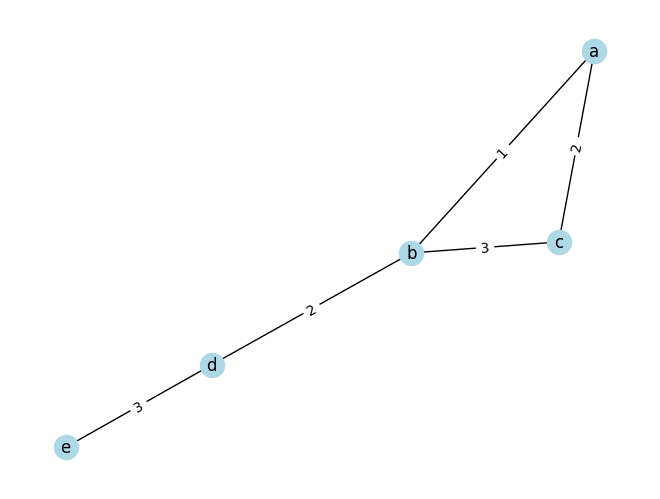

In [ ]:
wgraph.plot()

In [ ]:
!wget https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt

--2025-11-24 14:12:35--  https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt [following]
--2025-11-24 14:12:35--  https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114 [text/plain]
Saving to: ‘weighted0.txt.1’

weighted0.txt.1     100%[===================>]     114  --.-KB/s    in 0s      

2025-11-24 14:12:35 (2.74 MB/s) - ‘weighted0.txt.1’ saved [114/114]



A: B(3) E(10) 
B: A(3) C(26) D(12) 
E: A(10) D(7) F(8) H(4) 
C: B(26) D(17) F(13) G(14) 
D: B(12) C(17) E(7) F(15) 
F: C(13) D(15) E(8) G(9) H(6) 
G: C(14) F(9) H(16) I(11) 
H: E(4) F(6) G(16) 
I: G(11) 



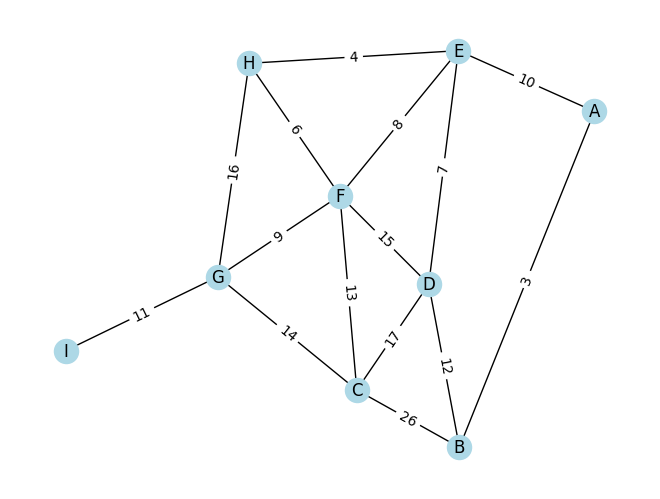

In [ ]:
wgraph1 = WeightedGraph.from_edges("weighted0.txt")
print(wgraph1)
wgraph1.plot()

63
A: B(3) E(10) 
B: A(3) 
E: A(10) H(4) D(7) 
H: E(4) F(6) 
F: H(6) G(9) C(13) 
D: E(7) 
G: F(9) I(11) 
I: G(11) 
C: F(13) 



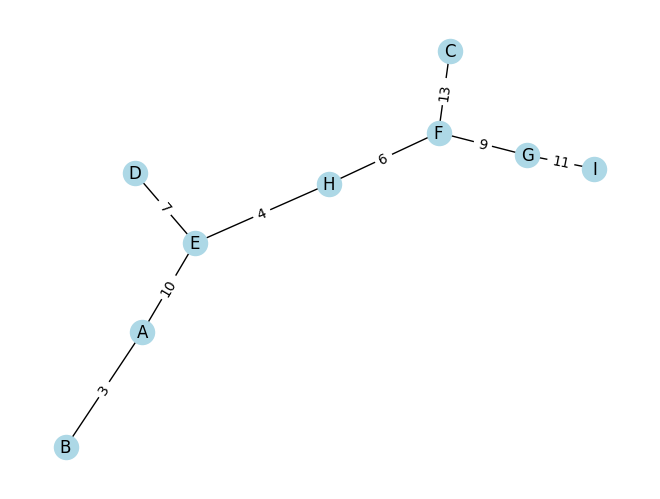

In [ ]:
total, wtree = wgraph1.min_spanning_tree()
print(total)
print(wtree)
wtree.plot()

In [ ]:
wgraph2 = deepcopy(wgraph1)
wgraph2.add_edge(["a", "e"])
print(wgraph2)

A: B(3) E(10) 
B: A(3) C(26) D(12) 
E: A(10) D(7) F(8) H(4) 
C: B(26) D(17) F(13) G(14) 
D: B(12) C(17) E(7) F(15) 
F: C(13) D(15) E(8) G(9) H(6) 
G: C(14) F(9) H(16) I(11) 
H: E(4) F(6) G(16) 
I: G(11) 
a: e(1) 
e: a(1) 



The graph is not connected! Returned is a spanning tree of some component.
63
A: B(3) E(10) 
B: A(3) 
E: A(10) H(4) D(7) 
H: E(4) F(6) 
F: H(6) G(9) C(13) 
D: E(7) 
G: F(9) I(11) 
I: G(11) 
C: F(13) 



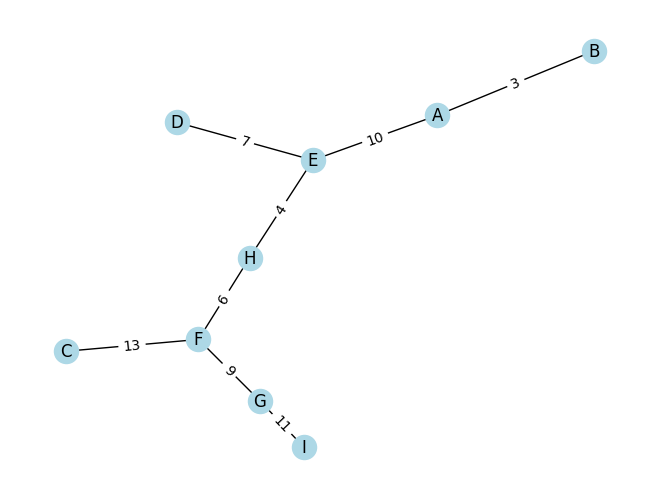

In [ ]:
total, wtree = wgraph2.min_spanning_tree()
print(total)
print(wtree)
wtree.plot()

## Part5
### Homework

Write a preorder(v) and postorder(v) function that will print trees (e.g. generated from Prüfer's code) in preorder or (respectively) postorder order, starting from vertex v.

In [ ]:
tree = Graph.tree_from_Prufer("3 5 5 5")

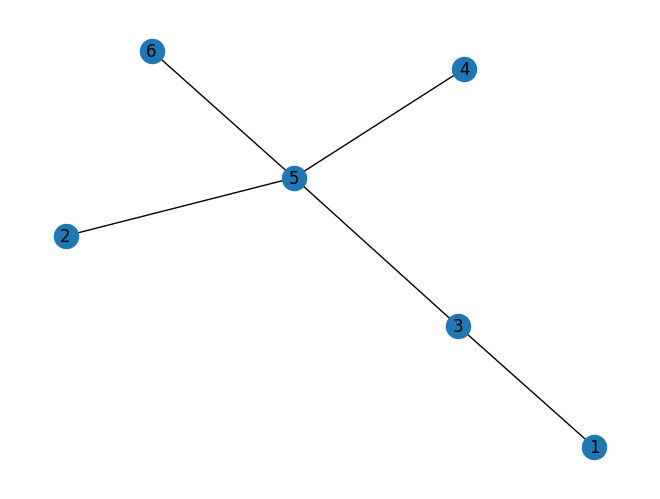

In [ ]:
tree.plot()

In [ ]:
tree.preorder(5)

5 2 3 1 4 6 

In [ ]:
tree.postorder(5)

2 1 3 4 6 5 

The ConnectedComponents function shown during classes returns a list of vertex sets. Write a ConnectedComponentsGraphs() function that returns a list of graphs — connected components of the graph on which is run. One can (worthwhile) use the (ready) ConnectedComponents function.

In [ ]:
graph1 = Graph.random_graph(10, 1/3)
for i, graph in enumerate(graph1.ConnectedComponentsGraphs()):
  print("Connected Component " + str(i+1) + ":")
  print(graph)

Connected Component 1:
1: 4 8 9 10
2: 4 5
3: 4 6 7 9 10
4: 1 2 3 5
5: 2 4 9 10
6: 3 7
7: 3 6
8: 1
9: 1 3 5 10
10: 1 3 5 9



Write a random_bipartite_graph(m,n, p)  function that will generate a bipartite random graph with m+n vertices (a subgraph of the graph K(m,n ) in which each possible pair of vertices is connected by an edge independently, with probability p.

In [ ]:
random_bipartite_graph = Graph.random_bipartite_graph(3,4,0.3)
print(random_bipartite_graph)

1: 4 5
2: 4
3: 7
4: 1 2
5: 1
6:
7: 3



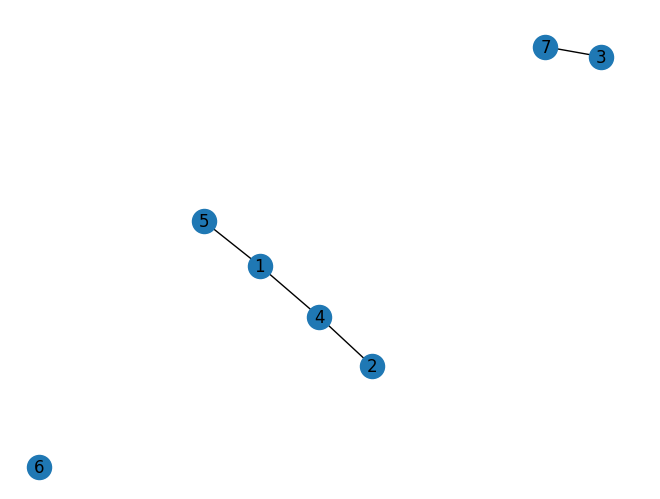

In [ ]:
random_bipartite_graph.plot()

### Distances in a graph

In [ ]:
!wget https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt

--2025-11-24 13:45:29--  https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt [following]
--2025-11-24 13:45:29--  https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114 [text/plain]
Saving to: ‘weighted0.txt’

weighted0.txt       100%[===================>]     114  --.-KB/s    in 0s      

2025-11-24 13:45:29 (1.34 MB/s) - ‘weighted0.txt’ saved [114/114]



A: B E
B: A C D
E: A D F H
C: B D F G
D: B C E F
F: C D E G H
G: C F H I
H: E F G
I: G
J: K
K: J



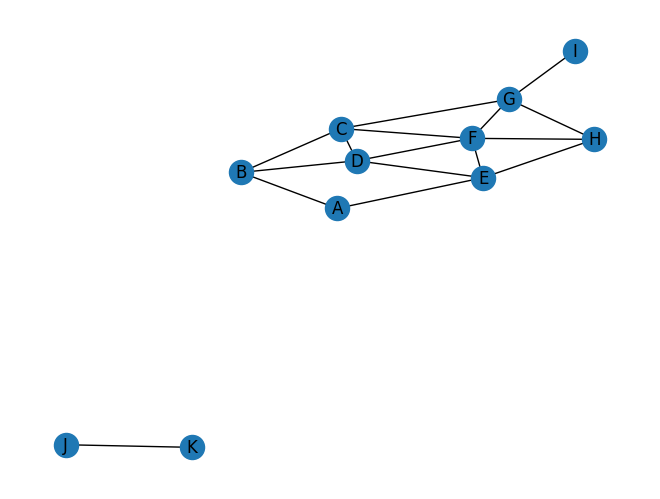

In [ ]:
graph1 = Graph.from_edges("weighted0.txt")
graph1.add_edge(["J", "K"])
print(graph1)
graph1.plot()

A: B
B: A C D
C: B D G
D: B C
G: C



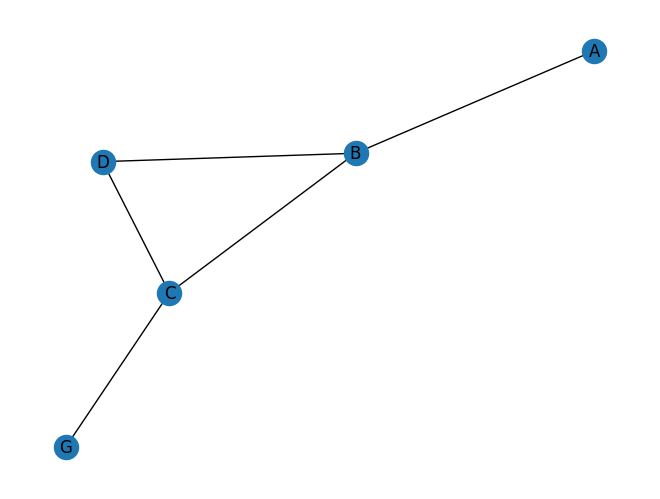

In [ ]:
subgraph = graph1.InducedSubgraph(["A", "B", "C", "D", "G"])
print(subgraph)
subgraph.plot()

In [ ]:
dist = graph1.distance("A")
print(dist)

{'A': 0, 'B': 1, 'E': 1, 'C': 2, 'D': 2, 'F': 2, 'H': 2, 'G': 3, 'I': 4}


In [ ]:
c_graph = graph1.ConnectedComponentsGraphs()[0]
print(c_graph)
print(c_graph.distance("A"))

I: G
E: A D F H
H: E F G
D: B C E F
G: C F H I
B: A C D
A: B E
C: B D F G
F: C D E G H

{'A': 0, 'B': 1, 'E': 1, 'C': 2, 'D': 2, 'F': 2, 'H': 2, 'G': 3, 'I': 4}


#### Millgram's experiment &mdash; Small World Phenomenon
We will look whether $G(n, p)$ (eg. G(4000, 1/600)) is a good illustration.

In [ ]:
n = 4000
p = 1/600
rgraph = Graph.random_graph(n, p)
graph = rgraph.ConnectedComponentsGraphs()[0]
print(len(graph.vertices()))

RecursionError: maximum recursion depth exceeded

In [ ]:
md = {}
ecc = {}
for v in graph.vertices():
  dist = graph.distance(v)
  md[v] = sum(dist.values())/len(dist)
  ecc[v] = max(dist.values())
print("Average distance:", sum(md.values())/len(md))
print("Radius: ", min(ecc.values()))
print("Diameter: ", max(ecc.values()))


### Part 4 (Connected components via DFS)

In [ ]:
graph1 = Graph.random_graph(100, 1/25)
#print(graph1)

In [ ]:
print(len(graph1.connected_components()))
print(graph1.connected_components())

### Part 3 (Prufer codes)

In [ ]:
%%writefile tree1.txt
1 3
3 5
2 5
4 5
6 5

In [ ]:
tree1 = Graph.from_edges("tree1.txt")

In [ ]:
print(tree1)

In [ ]:
print(tree1.Prufer())

In [ ]:
print(Graph.tree_from_Prufer("3 5 5 5"))

In [ ]:
print(Graph.tree_from_Prufer("5 4 3 1"))

In [ ]:
print(Graph.tree_from_Prufer("1 1 1 2 3"))

### Part2

In [ ]:
%%writefile edges.txt
a b
b c
b d
d
d c
e
f


In [ ]:
%cat edges.txt

In [ ]:
graph2 = Graph.from_edges("edges.txt")
print(graph2)

In [ ]:
graph2.to_neighbourlist("neighbourhood.txt")

In [ ]:
%cat "neighbourhood.txt"

In [ ]:
!wget https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt

In [ ]:
graph3 = Graph.from_edges("weighted0.txt")
print(graph3)

In [ ]:
# it works as well
!wget https://raw.githubusercontent.com/pgordin/GraphsSN2025/refs/heads/main/weighted0.txt

In [ ]:
graph4 = Graph.random_graph(10, 1/3)
print(graph4)

In [ ]:
print(Graph.cycle(6))

### Part1

In [ ]:
vertices = ["a", "b", "c", "d"]
matrix = np.array([[0,1,0,0],[1,0,1,0],[0,1,0,1],[0,0,0,1]])
print(vertices)
print(matrix)
print("---------------------------")
print_matrix(vertices, matrix)
print("---------------------------")
print_matrix(None,matrix)

In [ ]:
graph_dict = {
  "a": ["b"],
  "b": ["a", "c"],
  "c": ["b", "d"],
  "d": ["c"]
}
print(graph_dict)
print("---------------------------")
print_dict(graph_dict)

In [ ]:
graph1 = Graph.from_matrix(matrix, vertices)
print(graph1)

In [ ]:
print(Graph(graph_dict))  # the same result

In [ ]:
print(graph1.vertices())

In [ ]:
print(graph1.matrix())

In [ ]:
graph1.add_vertex("e")
print(graph1)

In [ ]:
graph1.add_edge(["e", "f"])
print(graph1)

In [ ]:
graph1.add_arc(["e", "a"])  # breaking the symmetry
print(graph1)

In [ ]:
graph1.add_edge(["e", "a"])  # restoring the symmetry
print(graph1)

In [ ]:
graph1.add_edge(["e", "f"]) # do nothing, an edge already exists
print(graph1)

In [ ]:
graph1.del_vertex("f")  # removing a vertex
print(graph1)

In [ ]:
graph1.add_edge(["e", "e"]) # an error

In [ ]:
graph1.add_arc(["e", "e"]) # OK - loops are allowed in digraphs
print(graph1)

In [ ]:
print(Graph.cycle(6))